In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
     
from fastbook import *

## Multicategory and regression

- Multicategory classification is finding more than one label per obect to classify, for instance images.
- Regression is classification when the labels are numbers instead.

### Multi-label classification

In the case of images, refers to the problem of indentifying the categories of objects in images. There may be more than one kind of object, or there may be no objects at all. Let's see an example.

### PASCAL dataset as example

This can have more than one kind of classified object per image. The dataset comes with a CSV file telling what labels to user for each image.

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [4]:
# filenames, also works df['name']
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

### Constructing a DataBlock from pandas DF

We can use the data block API for creating `DataLoaders`. PyTorch and fastai have two main classes for representing and accessing a training or validation set.

- `Dataset`: Collection that returns a tuble of your independent and dependent variable for a single item.
- `DataLoader`: An interator that provides a stream of mini-batches, where each mini-batch is a tuple of a batch of independent variables and a batch and dependent variables.

`DataLoader` buils on top of a `Dataset`. We can go step by step which is very recomended to always do.

In [5]:
# simple datablock
dblock = DataBlock()

In [6]:
# Creating datasets from a source, in this case our DataFrame
dsets = dblock.datasets(df)

In [7]:
# The datasets contains a train and valid datasets
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [8]:
x,y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object,
 fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

Be default the datablock assumes whe have an input and target. We will neeed to grab appropriate fields from the DataFrame using `get_x` and `get_y`.

In [9]:
x['fname']

'008663.jpg'

In [10]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

The independent variable will need to be converted into a complete path to open as an image, and dependent variable needs to be split on the space char

In [11]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/teamspace/studios/this_studio/.fastai/data/pascal_2007/train/002549.jpg'),
 ['tvmonitor'])

To open the image and do conversion to tensors we need a set of transforms. We will use `ImageBlock` and `MultiCategoryBlock`. This type of block expects to receive a list of strings.

In [12]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x325,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]))

The Categories are are *one-hot encoded* because PyTorch requires tensors, where everyting hast to be the same lenght 

In [13]:
# Checking what categoreis represent for this example.
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['train']

Up to now `DataBlock` has been using a random split by default. To avoid this we can take advantage that the dataset is already split using `is_valid`, so we need to write a function and pass it to `splitter`.

In [14]:
def splitter(df):
    """Returns two lists of integers, one for invalid and another for valids"""
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

As the individual items look fine, to create *mini-batches* using the `DataLoaders` we need to ensure that every item is of the same size. To do this, we can use `RandomResizedCrop`.

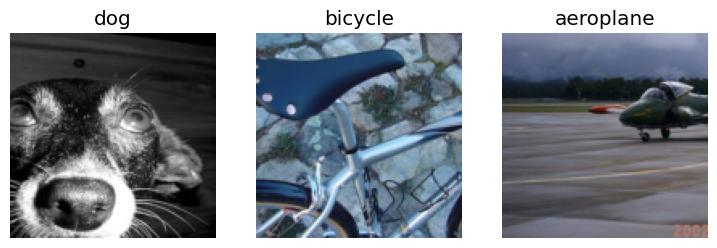

In [15]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

# display a sample of the data
dls.show_batch(nrows=1, ncols=3)

If something goes wrong when creating `DataLoaders` from a `DataBlock`, we can use `summary` to check.

In [16]:
dblock.summary(df)

Setting-up type transforms pipelines
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]
Found 5011 items
2 datasets of sizes 2501,2510
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False}
 -> OneHotEncode -- {'c': None}


Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      fname       000012.jpg
labels             car
is_valid         False
Name: 3, dtype: object
    applying get_x gives
      /teamspace/studios/this_studio/.fastai/d

## Binary Cross-Entropy

The `Learner` contains four objects:

- The model: We can use a model like `resnet`
- `DataLoaders`: We already built one
- An `Optimizer`: We know how to create `SDG` optimizer
- A **loss** function: We can use `vision_learner` to create a `Learner`, so we can look at its activations.

In [17]:
learn = vision_learner(dls, resnet18)

In [18]:
# Getting one mini-batch from our Data loader
x,y = to_cpu(dls.train.one_batch())
# Passing the independent variable of a mini-batch to the model
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

`activs` has this shape because we have a batch of size 64 and we are going to calculate the possiblity of 20 categories.

In [19]:
activs[0]

TensorImage([ 2.5979, -0.4562, -3.0337,  3.0538,  1.7064,  0.3729, -0.0540, -1.9583, -0.0492,  1.8134,  4.1722,  1.1499, -0.5534, -1.4648, -1.1612,  0.3000, -4.4436, -0.6878,  0.1498,  0.3290],
            grad_fn=<AliasBackward0>)

We will need to to scale between 0 to 1 and we can do using the `sigmoid` function. We can calculate a loss using `log`:

In [20]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

As we have a one-hot encoded dependent variable, we can't use `nn_loss` or `softmax` —we can't use `cross-entropy` loss directly.

- `softmax` won't apply to this case because it needs all predictions sum to 1, and due to the use of `exp` it tends to push one activation to be much larger than others —that is restricting to one prediction— We need multiple possible categories.
- `nll_loss` returns the value of just one activation: A single label for an item and this does not make sense when we have multiple labels.

We can use `binary_cross_entropy` function, which is `mnist_loss` with `log`. We can also take advantage of PyTorch elementwise operations. Each activation will be compared to the target of each column.

> PyTorch provides the function `F.binary_cross_entropy` and its equivalent module `nn.BCELoss` calculate cross-entropy on a one-hot enconded target. Normally for one-hot encoded targets `F.binary_cross_entropy_with_logits` is used (or `nn.BCEWithLogitsLoss`), which do both sigmoid and binary cross-entropy in a single function, as in the preceding example. We will use `nn.BCEWithLogitsLoss`.loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss
     

In [22]:
loss_func = nn.BCEWithLogitsLoss()     
loss = loss_func(activs, Tensor(y))     
loss

TensorImage(1.0821, grad_fn=<AliasBackward0>)

We will also need to change the metrics as we have to choose potentially multiply categories for each target, we can do it picking a *threshold*. Each value above the threshold will be considered a 1.

```python
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()
```

In [23]:
# let's try setting accuracy threshold to 0.2 for our metric
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.955646,0.697146,0.232092,02:29
1,0.828135,0.545552,0.288865,02:32
2,0.601254,0.193132,0.829701,02:34
3,0.355744,0.114271,0.949522,02:40


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.128715,0.105193,0.950837,03:16
1,0.114579,0.097357,0.956972,03:16
2,0.097062,0.094270,0.956653,03:13


It is important to pick a good thershold, if it is too low, many categories will be selected incorrectly. To see how weel the thershold is we can use `validate` which returns the validation loss and metrics.

There is a nice function in python `partial` which allows to *bind* a function with some arguments or keyword args. We will bund the thershold using `partial`.

In [24]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.09427022933959961,0.9375298619270325]

If you pick a threshold that's too high, you'll only be selecting the objects for which your model is very confident:

In [25]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.09427022933959961,0.9431672692298889]

To select the best thershold we can try a few levels. Let's try this approach

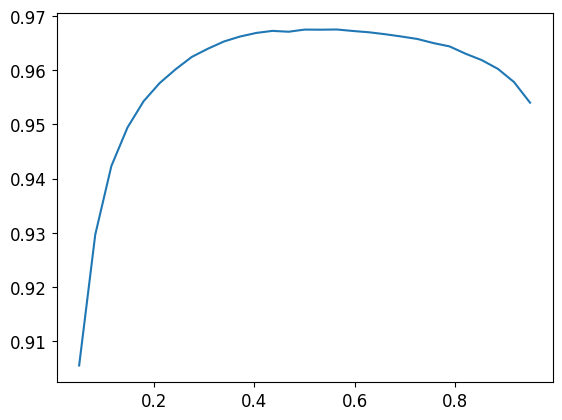

In [26]:
preds,targs = learn.get_preds()

xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

## Regression 